In [31]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
from io import BytesIO
import datetime
import numpy as np
import configparser
import sys
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm


In [3]:
sys.path.append("../..")
import micromet

In [4]:
config = configparser.ConfigParser()

config.read('../../secrets/config.ini')

from sqlalchemy import create_engine
import urllib.parse
host = config['DEFAULT']['ip']
pw = config['DEFAULT']['pw']
user = config['DEFAULT']['login']

encoded_password = urllib.parse.quote_plus(pw)

def postconn_et(encoded_password, host='localhost',user='postgres',port='5432',db='groundwater', schema = 'groundwater'):
    connection_text = "postgresql+psycopg2://{:}:{:}@{:}:{:}/{:}?gssencmode=disable".format(user,encoded_password,host,port,db)
    return create_engine(connection_text, connect_args={'options': '-csearch_path={}'.format(schema)})


engine = postconn_et(encoded_password, host=host, user=user)

In [51]:
station = 'US-UTE'

loggertypes = ["eddy","met"]

dfs = {}

for loggertype in loggertypes:
    table = f"amflux{loggertype}"
    query = f"SELECT * FROM {table} WHERE stationid = '{station}';"
    
    dfs[loggertype] = pd.read_sql(query, con = engine)
        



In [32]:
def scatterplot_instrument_comparison(edmet, compare_dict):
    # Compare two instruments
    instruments = list(compare_dict.keys())
    df = edmet[instruments].replace(-9999, np.nan).dropna()
    df = df.resample('1h').mean().interpolate(method='linear')
    df = df.dropna()

    x = df[instruments[0]]
    y = df[instruments[1]]

    xinfo = compare_dict[instruments[0]]
    yinfo = compare_dict[instruments[1]]

    # one to one line
    xline = np.arange(df.min().min(), df.max().max(), 0.1)
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # Predict y values
    y_pred = slope * x + intercept
    # R-squared
    r_squared = r_value ** 2

    fig, ax = plt.subplots(figsize=(10, 8))
    # Plot
    ax.scatter(x, y, alpha = 0.5, s = 1, label='Data points')
    ax.set_title(f'{xinfo[1]} Comparison: {station}')
    ax.plot(xline,xline, label='1:1 line', color='green', linestyle='--')
    ax.plot(x, y_pred, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.3f}')
    plt.legend()
    plt.grid(True)

    ax.set_xlabel(f'{xinfo[0]} {xinfo[1]} ({xinfo[2]})')
    ax.set_ylabel(f'{yinfo[0]} {yinfo[1]} ({yinfo[2]})')

    plt.show()

    # Print results
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_squared:.3f}")
    return slope, intercept, r_squared, p_value, std_err, fig, ax

def bland_alt_plot(edmet, compare_dict):
    instruments = list(compare_dict.keys())
    df = edmet[instruments].replace(-9999, np.nan).dropna()
    df = df.resample('1h').mean().interpolate(method='linear')
    df = df.dropna()

    x = df[instruments[0]]
    y = df[instruments[1]]
    rmse = np.sqrt(mean_squared_error(x, y))
    print(f"RMSE: {rmse:.3f}")

    mean_vals = df[instruments].mean(axis=1)
    diff_vals = x - y
    bias = diff_vals.mean()
    spread = diff_vals.std()
    print(f"Bias = {bias:.3f}, Spread = {spread:.3f}")
    top = diff_vals.mean() + 1.96 * diff_vals.std()
    bottom = diff_vals.mean() - 1.96 * diff_vals.std()

    f, ax = plt.subplots(1, figsize = (8,5))
    sm.graphics.mean_diff_plot(x, y, ax = ax)
    ax.text(mean_vals.mean(),top,s=compare_dict[instruments[0]][0],verticalalignment='top',fontweight='bold') 
    ax.text(mean_vals.mean(),bottom,s=compare_dict[instruments[1]][0],verticalalignment='bottom',fontweight='bold')
    ax.set_title(f'{compare_dict[instruments[0]][0]} vs {compare_dict[instruments[1]][0]} at {station}')
    ax.set_xlabel(f'Mean {compare_dict[instruments[0]][1]} ({compare_dict[instruments[0]][2]})')
    ax.set_ylabel(f'Difference ({compare_dict[instruments[0]][2]})\n({compare_dict[instruments[0]][0]} - {compare_dict[instruments[1]][0]})', fontsize=10)

    return f, ax

In [52]:
edmet = pd.merge(dfs['eddy'], dfs['met'], left_on='timestamp_start',right_on='timestamp_start', how='inner')
edmet['datetime'] = pd.to_datetime(edmet['timestamp_start'], format='%Y%m%d%H%M')
edmet = edmet.set_index('datetime').drop(['timestamp_start'], axis=1)
edmet = edmet[edmet.index > '2024-07-01']
#edmet = edmet.resample('1h').mean()

In [56]:
for col in edmet.columns:
    if 'g' in col:
        print(col)

co2_sigma
h2o_sigma
g
sg
mo_length
u_sigma
v_sigma
w_sigma
t_sonic_sigma
datalogger_no_x
battery_voltage
co2_sig_strgth_min
h2o_sig_strgth_min
datalogger_no_y
g_3_1_1


In [55]:
edmet[['g','g_3_1_1']].replace(-9999, np.nan).dropna()#.plot()


,g,g_3_1_1
datetime,,


In [48]:
compare_dict = {'g':['HFP','G','W/m2'],
                'g_3_1_1':['SoilVUE','G','W/m2'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)

ValueError: arange: cannot compute length

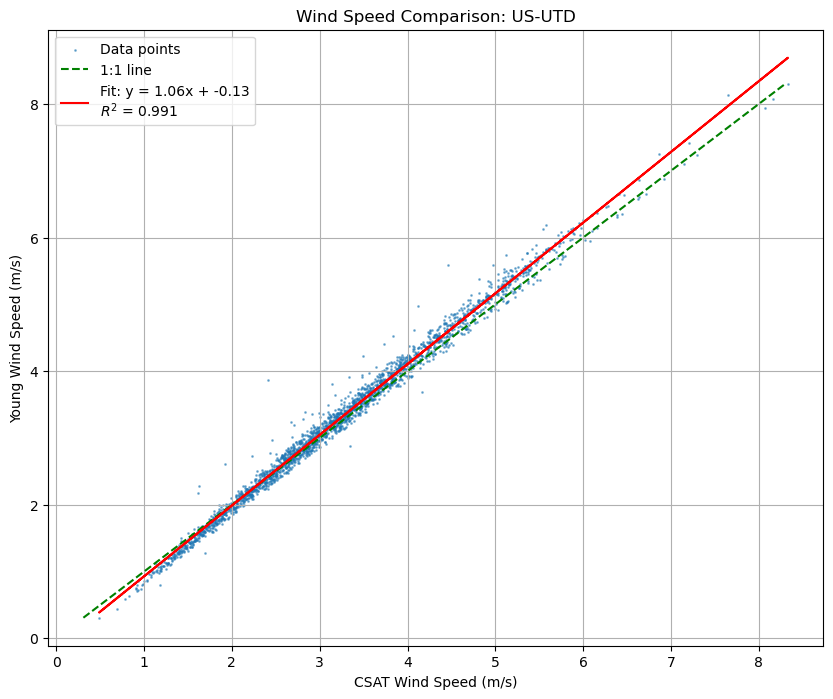

Slope: 1.059
Intercept: -0.130
R-squared: 0.991
RMSE: 0.154
Bias = -0.064, Spread = 0.140


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'CSAT vs Young at US-UTD'}, xlabel='Mean Wind Speed (m/s)', ylabel='Difference (m/s)\n(CSAT - Young)'>)

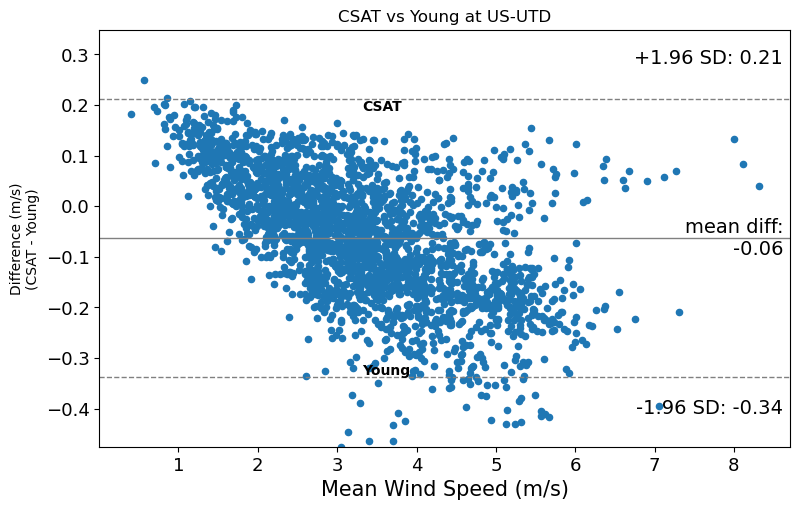

In [39]:
compare_dict = {'ws_x':['CSAT','Wind Speed','m/s'],
                'ws_y':['Young','Wind Speed','m/s'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)

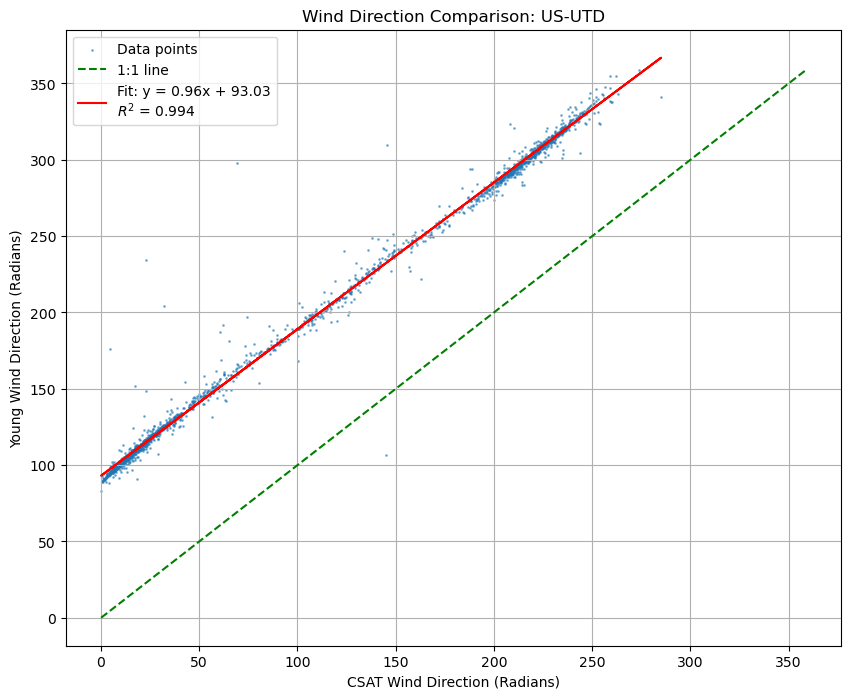

Slope: 0.961
Intercept: 93.034
R-squared: 0.994
RMSE: 89.733
Bias = -89.412, Spread = 7.587


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'CSAT vs Young at US-UTD'}, xlabel='Mean Wind Direction (Radians)', ylabel='Difference (Radians)\n(CSAT - Young)'>)

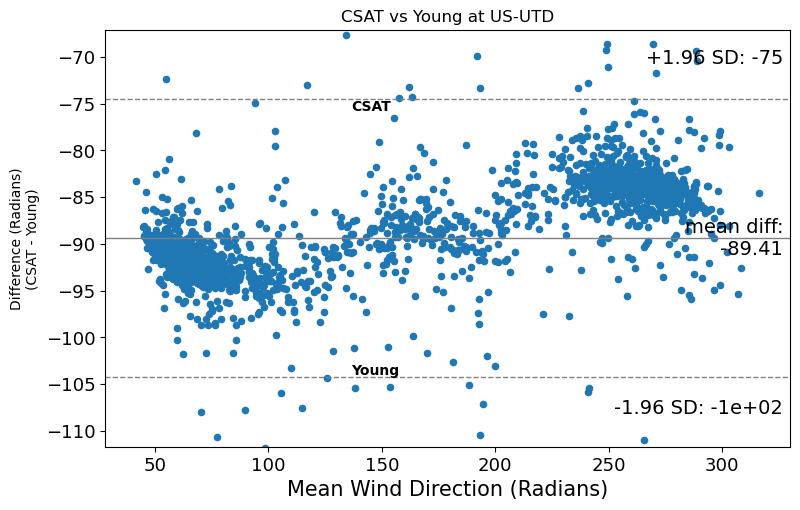

In [43]:
compare_dict = {'wd_x':['CSAT','Wind Direction','Radians'],
                'wd_y':['Young','Wind Direction','Radians'],}

edmet['wd_x_rad'] = np.deg2rad(edmet['wd_x'])
edmet['wd_y_rad'] = np.deg2rad(edmet['wd_y'])
edmet['wd_diff'] = edmet['wd_x'] - edmet['wd_y']
edmet2 = edmet[edmet['wd_diff'] < 180]
scatterplot_instrument_comparison(edmet2, compare_dict)
bland_alt_plot(edmet2, compare_dict)

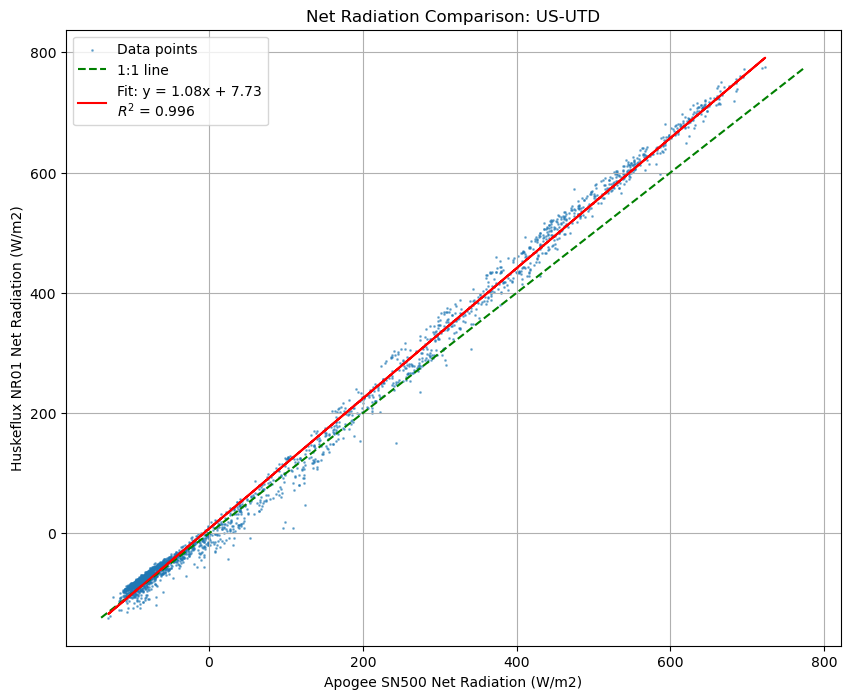

Slope: 1.083
Intercept: 7.735
R-squared: 0.996
RMSE: 31.515
Bias = -17.720, Spread = 26.066


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Apogee SN500 vs Huskeflux NR01 at US-UTD'}, xlabel='Mean Net Radiation (W/m2)', ylabel='Difference (W/m2)\n(Apogee SN500 - Huskeflux NR01)'>)

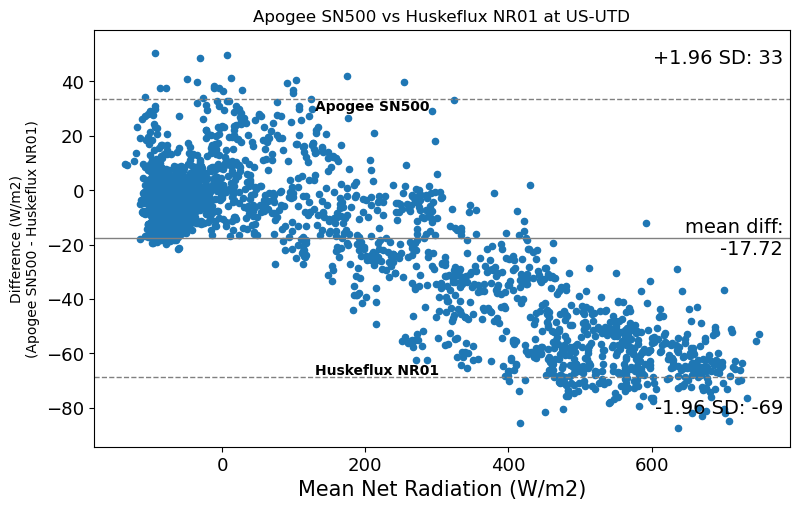

In [33]:


compare_dict = {'netrad_1_1_2':['Apogee SN500','Net Radiation','W/m2'],
                'netrad':['Huskeflux NR01','Net Radiation','W/m2'],}



scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)


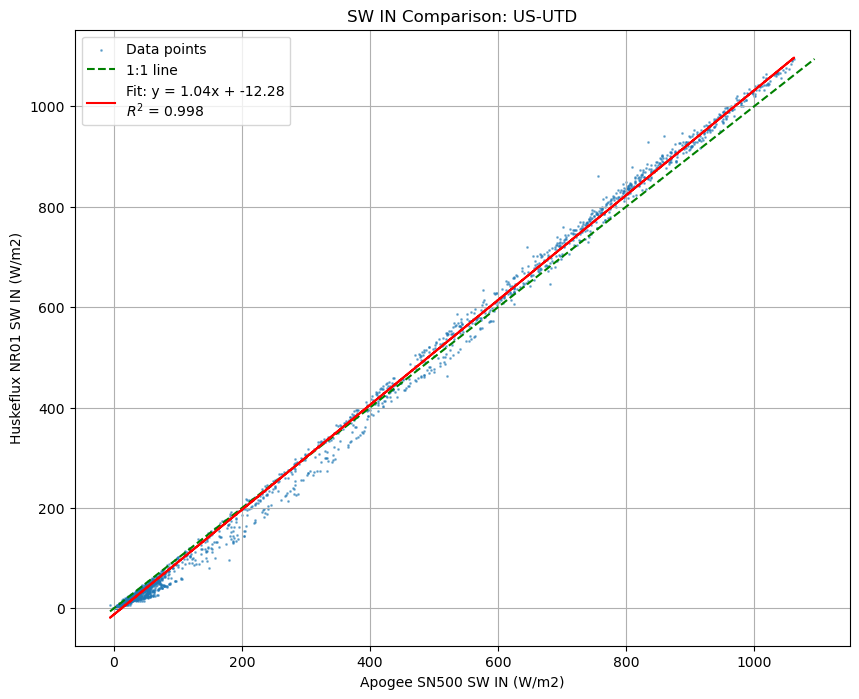

Slope: 1.044
Intercept: -12.279
R-squared: 0.998
RMSE: 20.326
Bias = -0.507, Spread = 20.324


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Apogee SN500 vs Huskeflux NR01 at US-UTD'}, xlabel='Mean SW IN (W/m2)', ylabel='Difference (W/m2)\n(Apogee SN500 - Huskeflux NR01)'>)

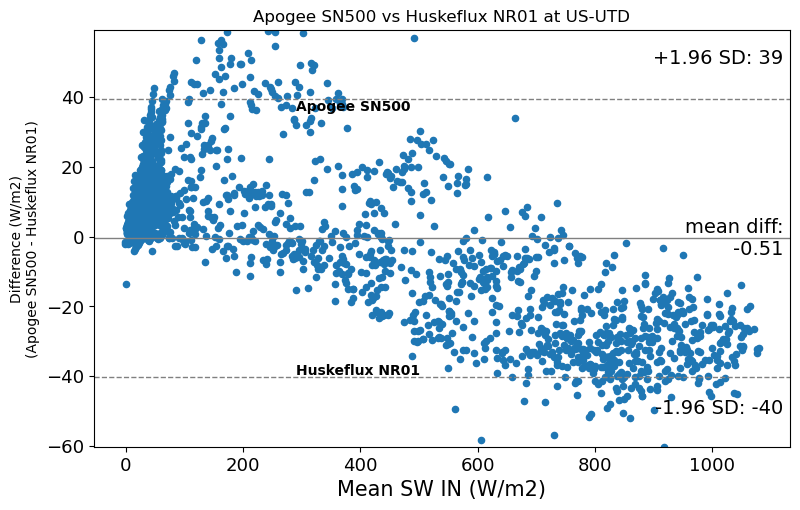

In [34]:
compare_dict = {'sw_in_1_1_2':['Apogee SN500','SW IN','W/m2'],
                'sw_in':['Huskeflux NR01','SW IN','W/m2'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)


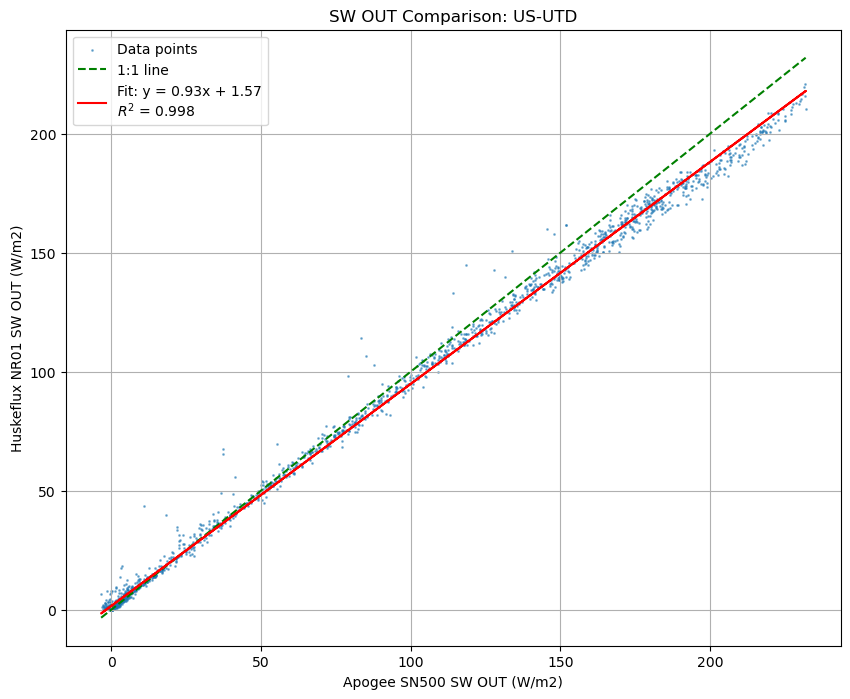

Slope: 0.933
Intercept: 1.565
R-squared: 0.998
RMSE: 6.613
Bias = 2.598, Spread = 6.082


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Apogee SN500 vs Huskeflux NR01 at US-UTD'}, xlabel='Mean SW OUT (W/m2)', ylabel='Difference (W/m2)\n(Apogee SN500 - Huskeflux NR01)'>)

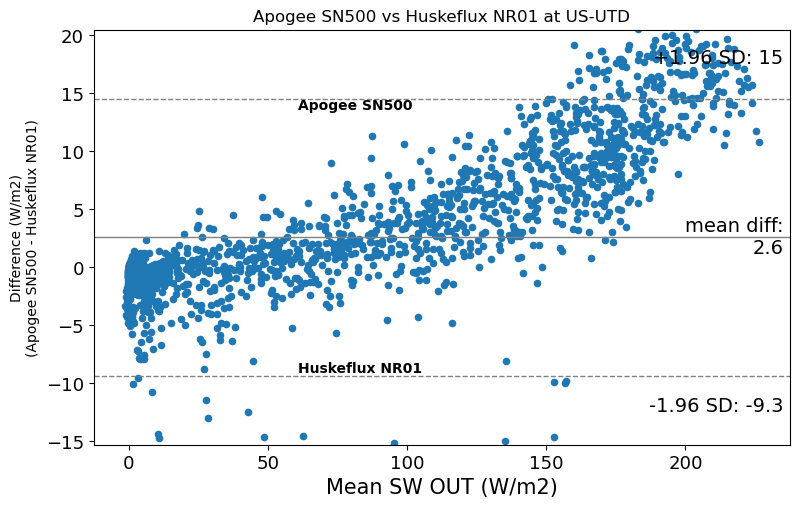

In [37]:
compare_dict = {'sw_out_1_1_2':['Apogee SN500','SW OUT','W/m2'],
                'sw_out':['Huskeflux NR01','SW OUT','W/m2'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)

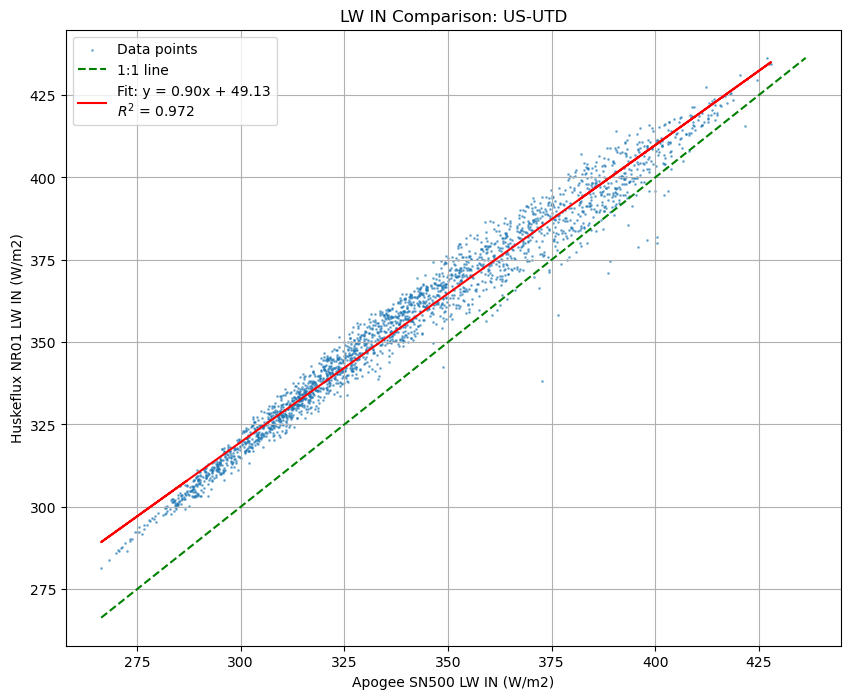

Slope: 0.902
Intercept: 49.126
R-squared: 0.972
RMSE: 16.883
Bias = -15.730, Spread = 6.135


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Apogee SN500 vs Huskeflux NR01 at US-UTD'}, xlabel='Mean LW IN (W/m2)', ylabel='Difference (W/m2)\n(Apogee SN500 - Huskeflux NR01)'>)

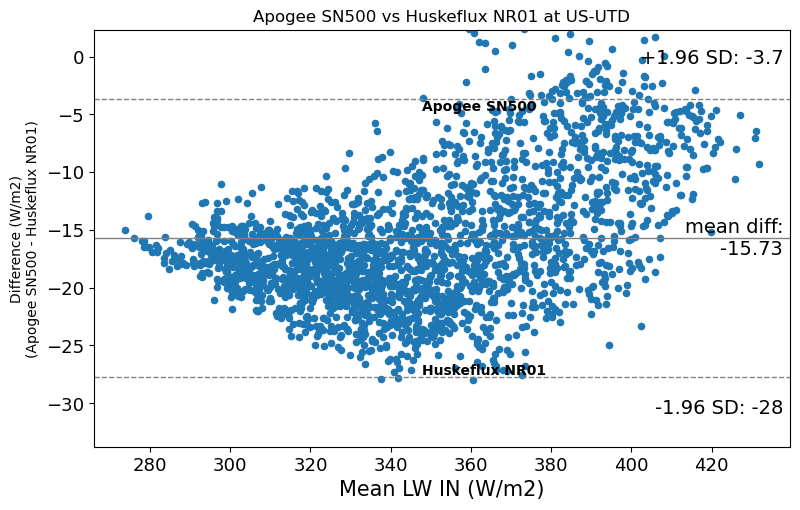

In [35]:
compare_dict = {'lw_in_1_1_2':['Apogee SN500','LW IN','W/m2'],
                'lw_in':['Huskeflux NR01','LW IN','W/m2'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)

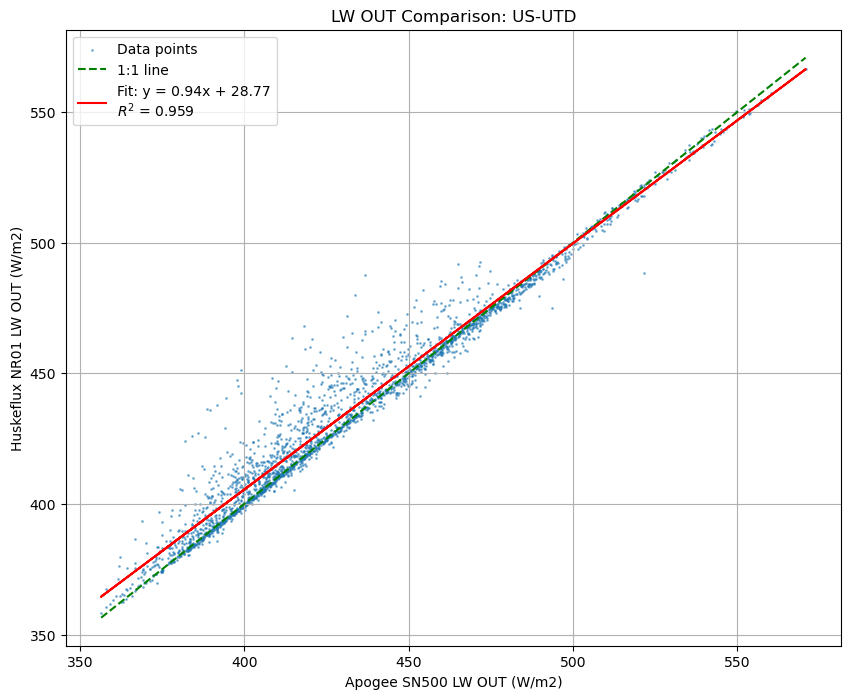

Slope: 0.942
Intercept: 28.771
R-squared: 0.959
RMSE: 8.866
Bias = -3.638, Spread = 8.087


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Apogee SN500 vs Huskeflux NR01 at US-UTD'}, xlabel='Mean LW OUT (W/m2)', ylabel='Difference (W/m2)\n(Apogee SN500 - Huskeflux NR01)'>)

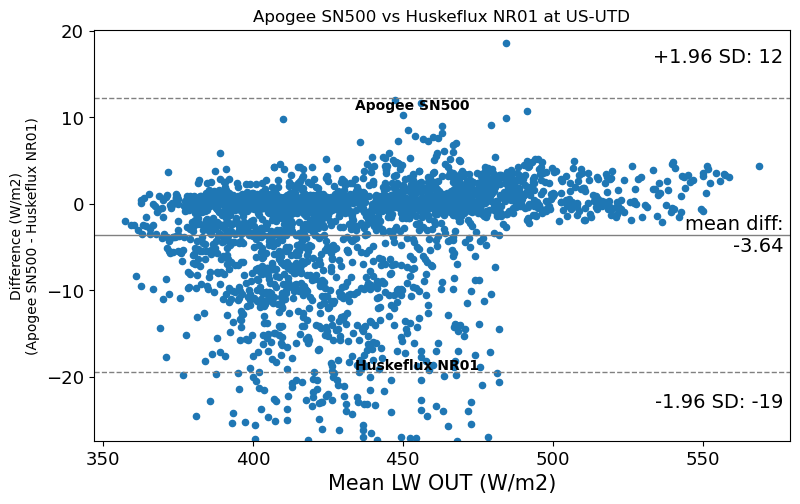

In [36]:
compare_dict = {'lw_out_1_1_2':['Apogee SN500','LW OUT','W/m2'],
                'lw_out':['Huskeflux NR01','LW OUT','W/m2'],}
scatterplot_instrument_comparison(edmet, compare_dict)
bland_alt_plot(edmet, compare_dict)